In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import matplotlib.pyplot as plt
import os
import pandas as pd


In [2]:
# Probably need to change this if your on MAC
spark = (
    SparkSession.builder.appName("Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '4g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/12 12:37:08 WARN Utils: Your hostname, Andy-PC resolves to a loopback address: 127.0.1.1; using 172.18.148.46 instead (on interface eth0)
24/09/12 12:37:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/12 12:37:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
merchant_fraud = spark.read.parquet("../data/curated/merchant_fraud")
merchant_fraud.show()

+------------+--------------+--------------------------+
|merchant_abn|order_datetime|merchant_fraud_probability|
+------------+--------------+--------------------------+
| 19492220327|    2021-11-28|        44.403658647495355|
| 31334588839|    2021-10-02|         42.75530083865367|
| 19492220327|    2021-12-22|        38.867790051131095|
| 82999039227|    2021-12-19|          94.1347004808891|
| 90918180829|    2021-09-02|         43.32551731714902|
| 31334588839|    2021-12-26|         38.36165958070444|
| 23686790459|    2021-12-10|          79.4543441508535|
| 14827550074|    2021-11-26|         46.45775596795885|
| 31334588839|    2021-11-26|         36.20971272078342|
| 19492220327|    2021-12-18|        33.819672154331755|
| 31334588839|    2021-11-29|        35.386213297375505|
| 14827550074|    2021-12-05|         43.85519494291279|
| 19492220327|    2021-11-18|        32.193139919494016|
| 93260930990|    2021-11-30|         37.87197154172081|
| 90918180829|    2021-09-16|  

In [4]:
full_transaction = spark.read.parquet("../data/curated/full_transaction")
full_transaction.show()

+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|postcode|gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|
+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+
|    2022-08-20| 96152467973|  11139|     505718|16.213590228273233|785b0080-9e4b-471...|    Monica Garrett|  NSW|    2281|Female|             NULL|Rhoncus Donec Ass...|[[tent and awning...|[tent and awning ...|    b| 4.45|                      NU

In [5]:
full_transaction = full_transaction.withColumn('order_time', F.unix_timestamp('order_datetime'))
full_transaction.show()

+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|postcode|gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|order_time|
+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+
|    2022-08-20| 96152467973|  11139|     505718|16.213590228273233|785b0080-9e4b-471...|    Monica Garrett|  NSW|    2281|Female|             NULL|Rhoncus Donec Ass...|[[tent and awning...|[tent and awning ...|   

Didn't include order_id.

In [6]:
continuous_features = ["dollar_value", "tags3", "order_time"]
categorical_features = ["merchant_abn", "user_id", "consumer_id", "consumer_name", "state", "postcode", "gender","tags2"]

In [7]:
# So we need to select our valid values first, we will take from the merchant fraud probability that we know.
merchant_fraud = spark.read.parquet("../data/curated/merchant_fraud")
print(f"Number of unique entries: {merchant_fraud.select('merchant_abn', 'order_datetime').distinct().count()}")
print(f"Number of entries: {merchant_fraud.count()}")

Number of unique entries: 114
Number of entries: 114


In [8]:
training_data = full_transaction.join(merchant_fraud,on=['merchant_abn', 'order_datetime','merchant_fraud_probability'],how='inner')
training_data = training_data.drop("fraud_probability")

In [9]:
for col in categorical_features:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip")
    training_data = indexer.fit(training_data).transform(training_data)

for col in categorical_features:
    encoder = OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vector")
    training_data = encoder.fit(training_data).transform(training_data)

assembler = VectorAssembler(
    inputCols=[f"{col}_vector" for col in categorical_features] + continuous_features,
    outputCol="feature_vector",
    handleInvalid="skip"
)
training_data = assembler.transform(training_data)

In [10]:
train_data, test_data = training_data.randomSplit([0.8, 0.2])
LR = LinearRegression(featuresCol='feature_vector', labelCol='merchant_fraud_probability')
LR_model = LR.fit(train_data)
results = LR_model.transform(test_data)
results.show(900)
training_summary = LR_model.summary
print("RMSE:", training_summary.rootMeanSquaredError)

24/09/12 12:37:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/12 12:37:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/09/12 12:37:27 WARN DAGSchedul

+------------+--------------+--------------------------+-------+-----------+------------------+--------------------+--------------------+-----+--------+-----------+--------------------+--------------------+--------------------+-----+-----+----------+------------------+-------------+-----------------+-------------------+-----------+--------------+------------+-----------+-------------------+-------------------+-------------------+--------------------+-------------+-------------------+-------------+-------------+--------------------+------------------+
|merchant_abn|order_datetime|merchant_fraud_probability|user_id|consumer_id|      dollar_value|            order_id|       consumer_name|state|postcode|     gender|       merchant_name|                tags|               tags1|tags2|tags3|order_time|merchant_abn_index|user_id_index|consumer_id_index|consumer_name_index|state_index|postcode_index|gender_index|tags2_index|merchant_abn_vector|     user_id_vector| consumer_id_vector|consumer_n

In [11]:
full_transaction.show()

+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|postcode|gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud_probability|order_time|
+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------------------+----------+
|    2022-08-20| 96152467973|  11139|     505718|16.213590228273233|785b0080-9e4b-471...|    Monica Garrett|  NSW|    2281|Female|             NULL|Rhoncus Donec Ass...|[[tent and awning...|[tent and awning ...|   

In [12]:
null_counts = full_transaction.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in full_transaction.columns])

null_counts.show()

+--------------+------------+-------+-----------+------------+--------+-------------+-----+--------+------+-----------------+-------------+------+------+------+------+--------------------------+----------+
|order_datetime|merchant_abn|user_id|consumer_id|dollar_value|order_id|consumer_name|state|postcode|gender|fraud_probability|merchant_name|  tags| tags1| tags2| tags3|merchant_fraud_probability|order_time|
+--------------+------------+-------+-----------+------------+--------+-------------+-----+--------+------+-----------------+-------------+------+------+------+------+--------------------------+----------+
|             0|           0|      0|          0|           0|       0|         8875| 8875|    8875|  8875|         14115157|       580863|580863|580863|580863|580863|                  14191623|         0|
+--------------+------------+-------+-----------+------------+--------+-------------+-----+--------+------+-----------------+-------------+------+------+------+------+---------

Text(0, 0.5, 'Density')

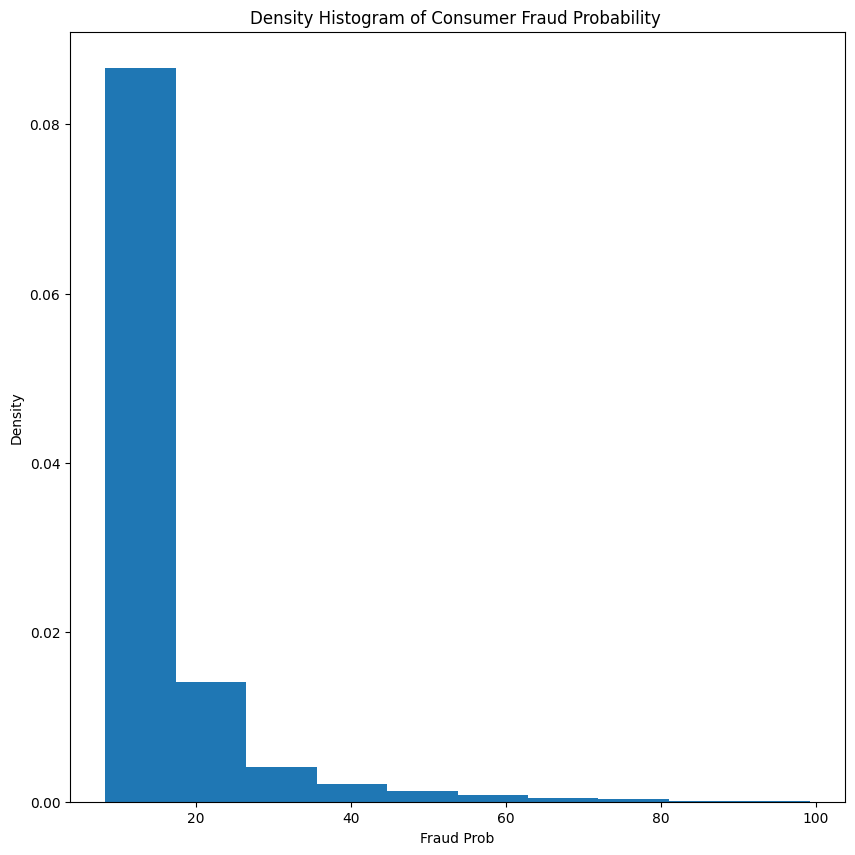

In [13]:
consumer_fraud = spark.read.parquet("../data/curated/consumer_fraud")
fraud = list(consumer_fraud.select("fraud_probability").toPandas()["fraud_probability"])
plt.figure(figsize=(10,10))
plt.hist(fraud, density = True)
plt.title('Density Histogram of Consumer Fraud Probability ')
plt.xlabel('Fraud Prob')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

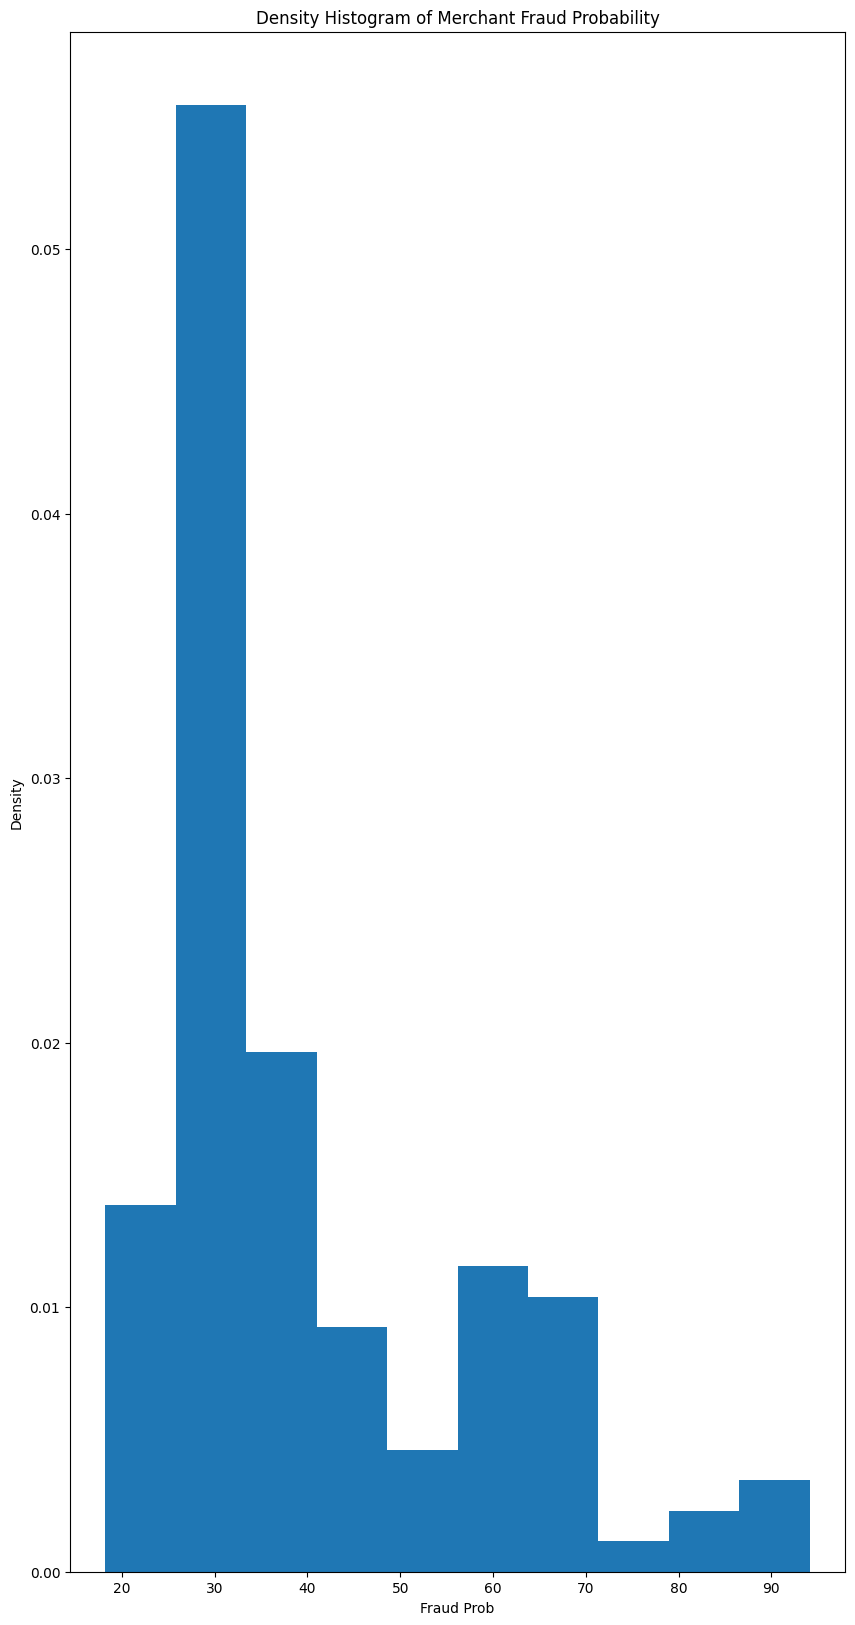

In [16]:
fraud = list(merchant_fraud.select("merchant_fraud_probability").toPandas()["merchant_fraud_probability"])
plt.figure(figsize=(10,10))
plt.hist(fraud, density = True)
plt.title('Density Histogram of Merchant Fraud Probability')
plt.xlabel('Fraud Prob')
plt.ylabel('Density')